# Student Information

Name: 李清濬

Student ID: C110110225

GitHub ID: AtilaJack

Kaggle name: 電腦與通訊工程系李清濬

## Kaggle private scoreboard snapshot: 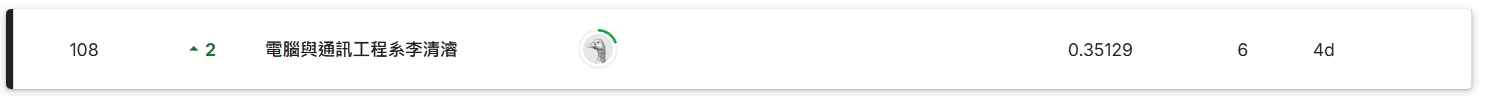

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt_tab')
from google.colab import drive
from tqdm import tqdm
drive.mount('/content/drive')
!pip install rank_bm25
!pip3 install scikit-learn
!pip3 install nltk

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
[
  {
    '_score': 433,
    '_index': 'hashtag_tweets',
    '_source':
          {'tweet':
                {
                  'hashtags': ['freepress', 'TrumpLegacy', 'CNN'],
                  'tweet_id': '0x2d5350',
                  'text': '@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN'
                }
          },
    '_crawldate': '2016-01-28 04:52:09', '_type': 'tweets'
  }
  ,
  {
    ....
  }
]
"""

"\n[\n  {\n    '_score': 433,\n    '_index': 'hashtag_tweets',\n    '_source':\n          {'tweet':\n                {\n                  'hashtags': ['freepress', 'TrumpLegacy', 'CNN'],\n                  'tweet_id': '0x2d5350',\n                  'text': '@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN'\n                }\n          },\n    '_crawldate': '2016-01-28 04:52:09', '_type': 'tweets'\n  }\n  ,\n  {\n    ....\n  }\n]\n"

### 資料集整理

In [3]:
# 讀tweets_DM.json

import json

file_path = '/content/drive/MyDrive/colab/lab02 kaggle/tweets_DM.json'

data = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line_number, line in tqdm(enumerate(file, start=1)):
        data.append(json.loads(line))

import pandas as pd

# 讀data_identification.csv
file_path = '/content/drive/MyDrive/colab/lab02 kaggle/data_identification.csv'
identification = pd.read_csv(file_path)

# 讀emotion.csv
file_path = '/content/drive/MyDrive/colab/lab02 kaggle/emotion.csv'
emotion = pd.read_csv(file_path)


# 拆分train/test
train_df = identification[identification['identification'] == 'train']
test_df = identification[identification['identification'] == 'test']

# 提取source資料
data_tweet = [i["_source"]["tweet"] for i in data]
data_tweet = pd.DataFrame(data_tweet)


#整合訓練資料
train = pd.merge(train_df, emotion, on='tweet_id', how='inner')
train = pd.merge(train, data_tweet, on='tweet_id', how='inner')
train = train.drop("identification", axis=1)

#整合測試資料
test = pd.merge(test_df, data_tweet, on="tweet_id", how="inner")
test = test.drop("identification", axis=1)


# 總資料 1867535
print("train set")
print(train)  # [1455563 rows x 4 columns] : id, emotion, hashtags, text
print()
print("test set")
print(test)  # [411972 rows x 3 columns] : id, hashtags, text

1867535it [01:01, 30466.57it/s]


train set
         tweet_id       emotion  \
0        0x29e452           joy   
1        0x2b3819           joy   
2        0x2a2acc         trust   
3        0x2a8830           joy   
4        0x20b21d  anticipation   
...           ...           ...   
1455558  0x227e25       disgust   
1455559  0x293813       sadness   
1455560  0x1e1a7e           joy   
1455561  0x2156a5         trust   
1455562  0x2bb9d2         trust   

                                                  hashtags  \
0                                                       []   
1                                        [spateradio, app]   
2                                                       []   
3        [PUBG, GamersUnite, twitch, BeHealthy, StayPos...   
4                                   [strength, bones, God]   
...                                                    ...   
1455558                                              [rip]   
1455559      [libtards, Hillary, lost, sad, growup, Trump]   
1455560    

In [4]:
print("訓練集資料分佈")
print(train["emotion"].value_counts())

訓練集資料分佈
emotion
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: count, dtype: int64


#訓練集抽樣
嘗試兩種抽樣

抽樣方法1: 依照原訓練集樣本比例抽樣

抽樣方法2: 每種emotion抽35000筆

皆為分層抽樣

In [5]:
# 訓練集進行分層抽樣 樣本數原樣本數 1/15
train_len = len(train)
total_sample = len(train)/2
emotion_counts = train['emotion'].value_counts()
print(emotion_counts)

# 抽樣方法1: 依照原訓練集樣本比例抽樣
# sample_sizes = (emotion_counts / train_len * total_sample).round().astype(int)
# sample_sizes.iloc[5:8] = emotion_counts.iloc[5:8]
# sample_train = train.groupby('emotion').apply(lambda x: x.sample(n=sample_sizes[x.name], random_state=1)).reset_index(drop=True)

# 抽樣方法2: 每種emotion抽35000筆
sample_train = train.groupby('emotion').apply(lambda x: x.sample(n=35000, random_state=1)).reset_index(drop=True)


# 將樣本洗牌
sample_train = sample_train.sample(frac=1, random_state=3).reset_index(drop=True)
print("\n打散後的資料:")
print(sample_train)

emotion
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: count, dtype: int64


<ipython-input-5-b7f8ea32771f>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_train = train.groupby('emotion').apply(lambda x: x.sample(n=35000, random_state=1)).reset_index(drop=True)



打散後的資料:
        tweet_id       emotion  \
0       0x29b8bf          fear   
1       0x2beabe          fear   
2       0x24d944  anticipation   
3       0x2194f4  anticipation   
4       0x225198  anticipation   
...          ...           ...   
279995  0x2a9403         anger   
279996  0x2052e8  anticipation   
279997  0x294a01       disgust   
279998  0x2ebb00       sadness   
279999  0x2ce383       disgust   

                                               hashtags  \
0                                                    []   
1                                                    []   
2                                                    []   
3                                                    []   
4                                                    []   
...                                                 ...   
279995                                               []   
279996         [ThursdayMotivation, Question, Thursday]   
279997                                             

In [6]:
# 抽樣後各類別樣本數
print(sample_train["emotion"].value_counts())

emotion
fear            35000
anticipation    35000
anger           35000
disgust         35000
joy             35000
surprise        35000
trust           35000
sadness         35000
Name: count, dtype: int64


#驗證集抽樣
抽訓練集1/15的樣本進行驗證

驗證集資料不包含到訓練集資料

In [7]:
# 驗證集進行分層抽樣 樣本數為原訓練集 1/15
train_len = len(train)
total_sample = len(train)//4
emotion_counts = train['emotion'].value_counts()
sample_sizes = (emotion_counts / train_len * total_sample).round().astype(int)
sample_val = train.groupby('emotion').apply(lambda x: x.sample(n=sample_sizes[x.name], random_state=40)).reset_index(drop=True)

# 將
inner = pd.merge(sample_val, sample_train, on="text", how="inner")
sample_val = sample_val[~sample_val['text'].isin(inner['text'])]


# 將樣本洗牌
sample_val = sample_val.sample(frac=1, random_state=4).reset_index(drop=True)
print("\n打散後的資料:")
print(sample_val)

<ipython-input-7-206e1b487966>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_val = train.groupby('emotion').apply(lambda x: x.sample(n=sample_sizes[x.name], random_state=40)).reset_index(drop=True)



打散後的資料:
        tweet_id       emotion  \
0       0x31ecd7       sadness   
1       0x25941e           joy   
2       0x2cae0e           joy   
3       0x2b8492  anticipation   
4       0x1e811d           joy   
...          ...           ...   
293549  0x2135fe           joy   
293550  0x37c893           joy   
293551  0x2da5ac           joy   
293552  0x227b27           joy   
293553  0x3347b4           joy   

                                                 hashtags  \
0                                                      []   
1                                            [B12vitamin]   
2       [Amazing, WildWendy, Tamiya, WildWilly, Clasic...   
3                                         [butterfingers]   
4                                                      []   
...                                                   ...   
293549                                   [PlayLikeABrown]   
293550                                                 []   
293551                           

In [8]:
print(sample_train["emotion"].value_counts())
print(sample_val["emotion"].value_counts())

emotion
fear            35000
anticipation    35000
anger           35000
disgust         35000
joy             35000
surprise        35000
trust           35000
sadness         35000
Name: count, dtype: int64
emotion
joy             120005
anticipation     53647
trust            42448
sadness          39505
disgust          26010
fear              7341
surprise          3373
anger             1225
Name: count, dtype: int64


# 資料清理
文本清洗

1.轉為小寫

2.去除標點符號和特殊字符

3.去除多餘空格

4.去除停用詞

In [9]:
# 清理文本、去除標點符號、特殊字符

import re
import nltk
from nltk.corpus import stopwords

# 確保下載 NLTK 的停用詞列表
nltk.download('stopwords')

# 定義文本清理函數
def clean_text(text):
    # 將文本轉換為小寫
    text = text.lower()

    # 去除標點符號和特殊字符
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 去除多餘空格
    text = re.sub(r'\s+', ' ', text).strip()

    # 去除停用詞
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(filtered_tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#訓練集、驗證集 清洗
clean = []
for text in tqdm(sample_train["text"]):
  cleaned_text = clean_text(text)
  clean.append(cleaned_text)

sample_train["text"] = clean

clean = []
for text in tqdm(sample_val["text"]):
  cleaned_text = clean_text(text)
  clean.append(cleaned_text)

sample_val["text"] = clean

100%|██████████| 293554/293554 [00:52<00:00, 5639.49it/s]


In [11]:
print(sample_train["text"])

print(sample_val["text"])

0               dog watching sniffing something cant see lh
1                                      episode brookcode lh
2         honestly say god return minute would prepared ...
3                                              wait text lh
4         let go negativities focus goal wooh malaki lak...
                                ...                        
279995    white guy kills 50 people senseless violence a...
279996    curious whats best drink first thing morning t...
279997    askjcp feel lh bogo 01 gets price two items so...
279998    made china japan love asked ngga holla racist ...
279999             imagine women acted like jeremy piven lh
Name: text, Length: 280000, dtype: object
0         andreacarnell aaronstew12 kylegriffin1 video t...
1                          secret 12 infowars lh b12vitamin
2         amazing wildwendy behind wheel tamiya wildwill...
3         iolitemusic vynyl ktclchannel933 know tweet ya...
4         wintry kind evening im bed listening fantastic..

In [12]:
# 測試集 清洗
clean = []
for text in tqdm(test["text"]):
  cleaned_text = clean_text(text)
  clean.append(cleaned_text)

test["text"] = clean

100%|██████████| 411972/411972 [01:12<00:00, 5700.05it/s]


In [13]:
#用於LLM embedding的資料
df_train = sample_train
df_val = sample_val

# BOW


嘗試不同特徵量

1024

512

In [14]:
# 最大特徵量 : 1024
from sklearn.tree import DecisionTreeClassifier
BOW_512 = CountVectorizer(max_features=1024, tokenizer=nltk.word_tokenize)
BOW_512.fit(sample_train["text"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=1024,
                tokenizer=<function word_tokenize at 0x78c1584decb0>)

In [15]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_512.transform(sample_train['text'])
y_train = sample_train['emotion']
X_test = BOW_512.transform(sample_val['text'])
y_test = sample_val['emotion']
## take a look at data dimension is a good habit :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (280000, 1024)
y_train.shape:  (280000,)
X_test.shape:  (293554, 1024)
y_test.shape:  (293554,)


####訓練決策樹

In [16]:

## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1, max_depth= 900)
## training!
DT_model = DT_model.fit(X_train, y_train)


In [17]:
# 樹深度
DT_model.get_depth()

900

In [18]:
## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)
## accuracy
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.87
testing accuracy: 0.33


### DT測試集 :
acc = 0.265 (最大特徵數:512)

acc = 0.238 (最大特徵數:1024)

In [19]:
X_TEST = BOW_512.transform(test['text'])
print('X_TEST: ', X_TEST.shape)

X_TEST:  (411972, 1024)


In [20]:
y_TEST_pred = DT_model.predict(X_TEST)
y_TEST_pred

array(['disgust', 'sadness', 'disgust', ..., 'joy', 'fear', 'anger'],
      dtype=object)

In [21]:
# Assuming y_TEST_pred and test["tweet_id"] are already defined from the previous code
# Create the DataFrame
result_df = pd.DataFrame({'id': test['tweet_id'], 'emotion': y_TEST_pred})
# Save the DataFrame to a CSV file
result_df.to_csv('result.csv', index=False)

### 神經網路:資料進行獨熱編碼，並訓練神經網路
acc : 0.326 (訓練資料為每個類別35000筆)

acc : 0.351 (依比例抽樣，抽原訓練集資料一半)

In [22]:
import keras
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)
def label_encode(le, labels):
 enc = le.transform(labels)
 return keras.utils.to_categorical(enc)
def label_decode(le, one_hot_label):
 dec = np.argmax(one_hot_label, axis=1)
 return le.inverse_transform(dec)
y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)
print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 0            fear
1            fear
2    anticipation
3    anticipation
Name: emotion, dtype: object

y_train.shape:  (280000,)
y_test.shape:  (293554,)


## After convert
y_train[0:4]:
 [[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]

y_train.shape:  (280000, 8)
y_test.shape:  (293554, 8)


In [23]:
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)
output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  1024
output_shape:  8


In [24]:
!pip3 install keras

In [25]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
# input layer
model_input = Input(shape=(input_shape, )) # 500
X = model_input
# 1st hidden layer
X_W1 = Dense(units=64)(X) # 64
H1 = ReLU()(X_W1)
# 2nd hidden layer
H1_W2 = Dense(units=64)(H1) # 64
H2 = ReLU()(H1_W2)
# output layer
H2_W3 = Dense(units=output_shape)(H2) # 4
H3 = Softmax()(H2_W3)
model_output = H3
# create model
model = Model(inputs=[model_input], outputs=[model_output])
# loss function & optimizer
model.compile(optimizer='adam',
 loss='categorical_crossentropy',
 metrics=['accuracy'])
# show model construction
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Softmax)                    │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,280 (274.53 KB)

 Trainable params: 70,280 (274.53 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('/content/drive/MyDrive/colab/training_log.csv',append=True)
# training setting
epochs = 3
batch_size = 32
# training!
history = model.fit(X_train, y_train,
 epochs=epochs,
 batch_size=batch_size,
 callbacks=[csv_logger],
 validation_data = (X_test, y_test))
print('training finish')

Epoch 1/3
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 127s 14ms/step - accuracy: 0.4217 - loss: 1.5499 - val_accuracy: 0.3791 - val_loss: 1.6463
Epoch 2/3
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - accuracy: 0.4309 - loss: 1.5298 - val_accuracy: 0.3737 - val_loss: 1.6447
Epoch 3/3
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 89s 7ms/step - accuracy: 0.4361 - loss: 1.5148 - val_accuracy: 0.3807 - val_loss: 1.6484
training finish


In [28]:
import numpy as np

## predict
pred_result = model.predict(X_test, batch_size=128)
print(pred_result[:5])
pred_result = label_decode(label_encoder, pred_result)
print(pred_result[:5])

from sklearn.metrics import accuracy_score
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

2294/2294 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
[[0.09202999 0.08231249 0.14128612 0.07459322 0.14656286 0.12251905
  0.2064827  0.13421357]
 [0.09068541 0.23379587 0.17137572 0.10877518 0.08807896 0.06879965
  0.12174214 0.11674698]
 [0.00365022 0.00412477 0.00856988 0.01743648 0.92084265 0.03542193
  0.00743165 0.00252244]
 [0.0644728  0.07675222 0.17369924 0.08427928 0.10015707 0.17547704
  0.21084014 0.1143222 ]
 [0.05065221 0.03065888 0.02508729 0.04999672 0.29469866 0.04551788
  0.08888587 0.4145025 ]]
['surprise' 'anticipation' 'joy' 'surprise' 'trust']
testing accuracy: 0.38


In [29]:
X_TEST = BOW_512.transform(test['text'])
print('X_TEST: ', X_TEST.shape)

pred_result = model.predict(X_TEST, batch_size=128)
print(pred_result[:5])
pred_result = label_decode(label_encoder, pred_result)

X_TEST:  (411972, 1024)
3219/3219 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
[[0.08485811 0.08729135 0.1404956  0.12366616 0.16344425 0.11785492
  0.18982232 0.09256732]
 [0.02605056 0.02720112 0.20928279 0.22951382 0.01350217 0.3666982
  0.08510321 0.04264816]
 [0.10508347 0.01856778 0.4152024  0.02576818 0.03097306 0.13484854
  0.23459582 0.03496077]
 [0.12214363 0.13051258 0.18933398 0.06822694 0.09276421 0.13676655
  0.14189321 0.11835881]
 [0.29946622 0.05837617 0.2876106  0.07117387 0.0220165  0.14153588
  0.0666195  0.05320135]]


In [30]:
# Create the DataFrame
result_df = pd.DataFrame({'id': test['tweet_id'], 'emotion': pred_result})
# Save the DataFrame to a CSV file
result_df.to_csv('/content/drive/MyDrive/colab/result.csv', index=False)

### LLM embedding : 將資料進行emembedding 後訓練神經網路
acc : 0 (embedding時間過長，跑不完)

利用llama3.2做embedding


In [ ]:
!pip install ollama

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) #runs on a different thread

In [ ]:
!ollama pull llama3.2

In [ ]:
import pandas as pd
import ollama
# Let's copy our dataframes for training and testing
df_train = sample_train
df_val = sample_val
# Define a function to generate embeddings
def generate_embeddings(row,text_column_name='text'):
 embeddings = ollama.embeddings(
 model='llama3.2',
 prompt=row[text_column_name],
 )
 return embeddings["embedding"]

In [ ]:
column_name = 'text'
# Apply the function to the specified column and store the result in a new column 'embeddings'
df_train['embeddings'] = df_train.apply(lambda row: generate_embeddings(row, column_name), axis=1)
df_val['embeddings'] = df_val.apply(lambda row: generate_embeddings(row, column_name), axis=1)

In [ ]:
print(df_train)
print(df_val)

In [ ]:
X_llama_train = np.vstack(df_train["embeddings"].to_numpy()) #Defining our train set
X_llama_test = np.vstack(df_val["embeddings"].to_numpy()) #Defining our test set
print(X_llama_train.shape) #(Number of data, Llama 3.2 embedding size)
print(X_llama_test.shape) #(Number of data, Llama 3.2 embedding size)

In [ ]:
#One-hot encoding our labels
y_train_llama = label_encode(label_encoder, y_train)
y_test_llama = label_encode(label_encoder, y_test)

# I/O check
input_shape_llama = len(X_llama_train[0])
print('input_shape: ', input_shape_llama)
output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

In [ ]:
#We try the same Neural Network Model Again
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
# input layer
model_input = Input(shape=(input_shape_llama, )) # 3072
X = model_input
# 1st hidden layer
X_W1 = Dense(units=64)(X) # 64
H1 = ReLU()(X_W1)
# 2nd hidden layer
H1_W2 = Dense(units=64)(H1) # 64
H2 = ReLU()(H1_W2)
# output layer
H2_W3 = Dense(units=output_shape)(H2) # 4
H3 = Softmax()(H2_W3)
model_output = H3
# create model
model = Model(inputs=[model_input], outputs=[model_output])
# loss function & optimizer
model.compile(optimizer='adam',
 loss='categorical_crossentropy',
 metrics=['accuracy'])
# show model construction
model.summary() #We can notice that our parameter numbers went up because of the increase in the dimension of our input

In [ ]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('/content/drive/MyDrive/colab/training_log.csv',append=True)
# training setting
epochs = 25
batch_size = 32
# training!
history = model.fit(X_llama_train, y_train_llama,
 epochs=epochs,
 batch_size=batch_size,
 callbacks=[csv_logger],
 validation_data = (X_llama_test, y_test_llama))
print('training finish')

In [ ]:
pred_result = model.predict(X_llama_test, batch_size=128)
pred_result[:5]
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]
from sklearn.metrics import accuracy_score
#Accuracy
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test_llama), pred_result), 2)))

In [ ]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("/content/drive/MyDrive/colab/training_log.csv")
training_log

In [ ]:
# Create the DataFrame
result_df = pd.DataFrame({'id': test['tweet_id'], 'emotion': pred_result})
# Save the DataFrame to a CSV file
result_df.to_csv('/content/drive/MyDrive/colab/result.csv', index=False)